In [22]:
# data visualiztion
import matplotlib.pyplot as plt
import seaborn as sns

# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# for linear regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
from statsmodels.formula.api import ols
import scipy.stats as stats

# recursive feature elimination (w/ cross validation), linear regression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

# Variance inflation factor, mean abs/squarred error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")

# make stuff look cooler
plt.style.use('fivethirtyeight')

In [17]:
# creates dictionary of variance inflation factors. 
def create_vif_dictionary(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    good_vifs = []
    bad_vifs = []

    for k,v in vif_dict.items():
        if v < 10:
            good_vifs.append(k)
        else:
            bad_vifs.append(k)

    return good_vifs,bad_vifs

# create a dictionary showing the adjusted R-squared values for each feature individually
def create_R2_dictionary(X,y):

    adj_R_squares = {}

    for feature in X.columns:
        predictors_int = sm.add_constant(X[feature])
        model = sm.OLS(y,predictors_int).fit()
        adj_R_square = float(model.summary2().tables[0][3][0])
        adj_R_squares[feature] = adj_R_square
        
    return adj_R_squares

# author's docstring is in a markup cell down below in the stepwise selection section
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)

    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.pop(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

# recursive feature elimination
def run_RFE(X,y):

    linreg = LinearRegression()
    selector = RFE(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass
    return selections, rankers

# recuersive feature elimination with cross validation
def run_RFECV(X,y):

    linreg = LinearRegression()
    selector = RFECV(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass

    return selections, rankers

# returns OLS linear regression model
def run_OLS_model(X,y):

    predictors_int = sm.add_constant(X)
    model = sm.OLS(y,predictors_int).fit()

    return model

# returns dictionary: keys are column labels, values are count of NaN values present
def create_NaN_dictionary(X):

    NaN_dict = {}

    for feature in X.columns:
        NaN_dict[feature] = sum(X[feature].isna())

    return NaN_dict



In [3]:
data = pd.read_csv('data/base_model.csv')

Baseline model was fairly strong in the EDA notebook but the Jarque-Bera test was not in favor of normality.
- First plan of action is to eliminate outliers in the target variable and observe how this will affect the model. 

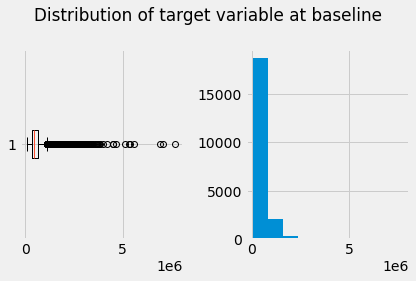

In [4]:
# target variable clearly shows an excessive volume of outliers
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.boxplot(data.price,vert=False)
ax2.hist(data.price)

fig.suptitle("Distribution of target variable at baseline")
plt.tight_layout()
plt.show()

### Removing outliers:
- based on statistical max: to account for outliers and reflect the plot above statistical max is represented by inter quartile range multiplied by 1.5, in lieu of actual maximum value.
- based on standard deviation: removing any values more than 3 standard deviations from the mean
- arbitrary trim: removing the top 5% most extreme values

Defining thresholds to investigate

In [5]:
iqr = data.price.quantile(0.75) - data.price.quantile(0.25)
max_thresh = iqr*1.5 # statistical maximum 

std_thresh = data.price.std()*3 # three standard deviations

top_5_percentile = data.price.quantile(0.95) #95th percentile (top 5% highest values)

Stastical Maximum

In [6]:
max_cap = data['price'].loc[abs(data['price']) <= max_thresh] # keeping data only at or within the statistical maximum. 

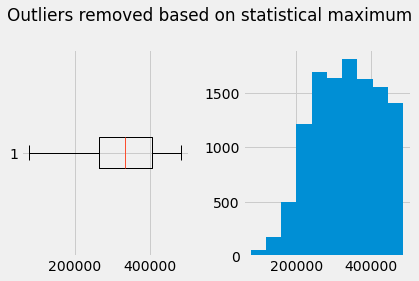

Percent of data retained:  0.5521
this box plot indicates the data will be better suited for the regression model, however it has dropped about half the data... 


In [7]:
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.boxplot(max_cap,vert=False)
ax2.hist(max_cap)

fig.suptitle("Outliers removed based on statistical maximum")
plt.tight_layout()
plt.show()

print('Percent of data retained: ',round(len(max_cap)/len(data.price),4))  
print('this box plot indicates the data will be better suited for the regression model, however it has dropped about half the data... ')

3 standard deviations

In [8]:
std_cap = data['price'].loc[abs(data['price']) <= std_thresh]

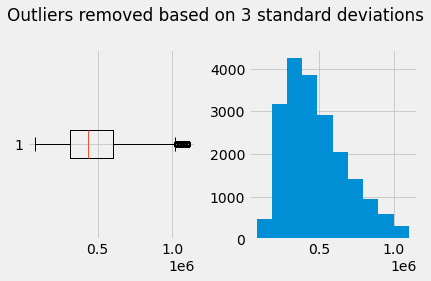

Percent of data retained:  0.9451
boxplot shows retention of some outliers, but the histogram is closer to normal than max_cap and retain most of the data (nearly all of it)


In [9]:
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.boxplot(std_cap,vert=False)
ax2.hist(std_cap)

fig.suptitle("Outliers removed based on 3 standard deviations")
plt.tight_layout()
plt.show()

print('Percent of data retained: ',round(len(std_cap)/len(data.price),4))  
print('boxplot shows retention of some outliers, but the histogram is closer to normal than max_cap and retain most of the data (nearly all of it)')

In [10]:
top_5_cap = data['price'].loc[abs(data['price']) < top_5_percentile]

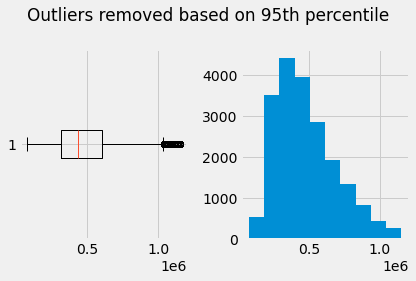

Percent of data retained:  0.9496
extremely similar results to elimination based on standard devation, retains slightly more data


In [11]:
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.boxplot(top_5_cap,vert=False)
ax2.hist(top_5_cap)

fig.suptitle("Outliers removed based on 95th percentile")
plt.tight_layout()
plt.show()

print('Percent of data retained: ',round(len(top_5_cap)/len(data.price),4))  
print('extremely similar results to elimination based on standard devation, retains slightly more data')

#### Observations on elimination of outliers 

Elimination based on statistical maximum eliminated way too much data so it wan't be investigated further, full-stop. 
Elimination based on 95th percentile retained slightly more data than elmination based on 3 standard deviaitons... However both results round to 95% of the data retained; considering the whole goal is to actually *eliminate* outliers, not just some arbitrary slice of data, I will continue with the data with outliers eliminated based on 3 standard deviations because this is a statistical method and not an arbitrary slice. 

In [13]:
data = data.loc[abs(data.price) <= std_thresh] # slicing data to eliminate outliers using selected method
y = data.price
X = data.iloc[:,1:] # every column except price

In [15]:
base_model = run_OLS_model(X,y)
# base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     1192.
Date:                Sun, 27 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:09:05   Log-Likelihood:            -2.6506e+05
No. Observations:               19982   AIC:                         5.302e+05
Df Residuals:                   19961   BIC:                         5.303e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -2.937e+07   6.45e+06     -4.552      0.000    -4.2e+07   -1.67e+07
date                          45.6719      8.773      5.206      0.000      28.476      62.867
floors                      1.906e+04   3108.866      6.131      0.000     1.3e+04    2.52e+04
waterfront                   1.04e+05   2.08e+04      5.005      0.000    6.33e+04    1.45e+05
view                        2.665e+04   1692.625     15.747      0.000    2.33e+04       3e+04
condition                   2.295e+04   1684.809     13.624      0.000    1.97e+04    2.63e+04
sqft_basement                408.4141      4.298     95.014      0.000     399.989     416.839
yr_built                   -2174.1048     47.486    -45.784      0.000   -2267.181   -2081.029
yr_renovated                  14.4432      3.020      4.783      0.000       8.525      20.362
bed_bath_ratio             -2.427e+04   1742.460    -13.930      0.000   -2.77e+04   -2.09e+04
level_ratio                 3213.0636    419.332      7.662      0.000    2391.138    4034.989
live_lot_ratio              1.506e+05   5263.583     28.616      0.000     1.4e+05    1.61e+05
relative_living_space        -97.4686      2.600    -37.493      0.000    -102.564     -92.373
relative_lot_size              0.2523      0.035      7.209      0.000       0.184       0.321
level_difference             216.5617      2.130    101.676      0.000     212.387     220.736
waterfront_Duwamish        -1.155e+05   8774.595    -13.162      0.000   -1.33e+05   -9.83e+04
waterfront_Elliott Bay       5.68e+04   6149.788      9.237      0.000    4.47e+04    6.89e+04
waterfront_Lake Sammamish   8.907e+04   4659.082     19.116      0.000    7.99e+04    9.82e+04
waterfront_Lake Union       1.472e+05   1.56e+04      9.449      0.000    1.17e+05    1.78e+05
waterfront_Lake Washington  5.372e+04   6841.557      7.852      0.000    4.03e+04    6.71e+04
waterfront_Puget Sound     -8.386e+04   7355.422    -11.401      0.000   -9.83e+04   -6.94e+04
==============================================================================
Omnibus:                     1065.053   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1423.841
Skew:                           0.511   Prob(JB):                    6.56e-310
Kurtosis:                       3.817   Cond. No.                     4.81e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[('Jarque-Bera', 1423.8409541062915), ('Prob', 6.5594173145438e-310), ('Skew', 0.5106814712897342), ('Kurtosis', 3.8166798748000956)]


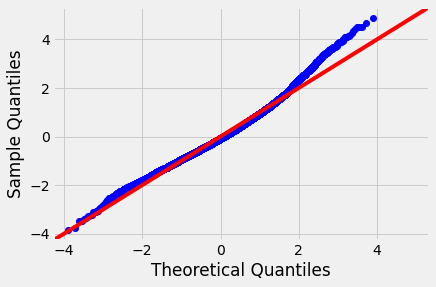

In [18]:
base_residual = base_model.resid

fig = sm.graphics.qqplot(base_residual, dist=stats.norm, line='45', fit=True)

name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(base_residual)
print(list(zip(name, test)))

Observations on base model:
- Skewness and Kurtosis are not extremely off target, but off nonetheless. 
- P-value and JB are even worse than the final model in the previous notebook (EDA 4)

Log transform target variable to further fit the data. 

[('Jarque-Bera', 1423.8409541062915), ('Prob', 6.5594173145438e-310), ('Skew', 0.5106814712897342), ('Kurtosis', 3.8166798748000956)]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     1107.
Date:                Sun, 27 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:39:24   Log-Likelihood:                -4676.4
No. Observations:               19982   AIC:                             9395.
Df Residuals:                   19961   BIC:                             9561.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -57.2391     14.141     -4.048      0.000     -84.956     -29.522
date                           0.0001   1.92e-05      5.493      0.000    6.79e-05       0.000
floors                         0.0556      0.007      8.158      0.000       0.042       0.069
waterfront                     0.2363      0.046      5.189      0.000       0.147       0.326
view                           0.0435      0.004     11.736      0.000       0.036       0.051
condition                      0.0505      0.004     13.685      0.000       0.043       0.058
sqft_basement                  0.0009   9.42e-06     90.858      0.000       0.001       0.001
yr_built                      -0.0043      0.000    -41.796      0.000      -0.005      -0.004
yr_renovated                2.391e-05   6.62e-06      3.614      0.000    1.09e-05    3.69e-05
bed_bath_ratio                -0.0623      0.004    -16.324      0.000      -0.070      -0.055
level_ratio                    0.0072      0.001      7.828      0.000       0.005       0.009
live_lot_ratio                 0.3342      0.012     28.975      0.000       0.312       0.357
relative_living_space         -0.0002    5.7e-06    -36.147      0.000      -0.000      -0.000
relative_lot_size           5.502e-07   7.67e-08      7.175      0.000       4e-07    7.01e-07
level_difference               0.0004   4.67e-06     93.525      0.000       0.000       0.000
waterfront_Duwamish           -0.3710      0.019    -19.295      0.000      -0.409      -0.333
waterfront_Elliott Bay         0.1495      0.013     11.092      0.000       0.123       0.176
waterfront_Lake Sammamish      0.1930      0.010     18.901      0.000       0.173       0.213
waterfront_Lake Union          0.2839      0.034      8.316      0.000       0.217       0.351
waterfront_Lake Washington     0.1379      0.015      9.201      0.000       0.109       0.167
waterfront_Puget Sound        -0.1818      0.016    -11.281      0.000      -0.213      -0.150
==============================================================================
Omnibus:                      130.039   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.928
Skew:                          -0.171   Prob(JB):                     6.79e-31
Kurtosis:                       3.225   Cond. No.                     4.81e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

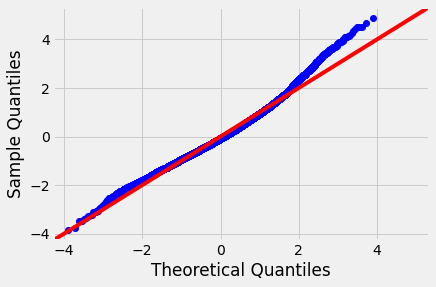

In [32]:
y_log = np.log(y)

log_model = run_OLS_model(X,y_log)
log_residual = log_model.resid

name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(base_residual)


fig = sm.graphics.qqplot(base_residual, dist=stats.norm, line='45', fit=True)

print(list(zip(name, test)))
log_model.summary()



In [34]:
y_log.describe()
first = y_log.loc[y_log < ]

count    19982.000000
mean        12.977716
std          0.444073
min         11.264464
25%         12.660328
50%         12.986887
75%         13.304685
max         13.910821
Name: price, dtype: float64

Inspect cross validation

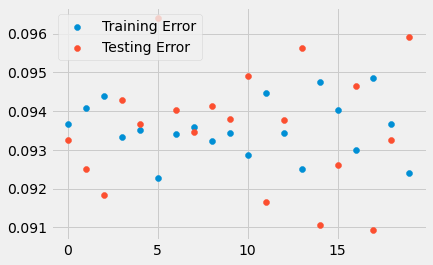

In [21]:
num = 20
train_err = []
test_err = []
linreg = LinearRegression()

for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.33)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
    
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend();

In [28]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', round(mse_train,3))
print('Test Mean Squarred Error:', round(mse_test,3))

Train Mean Squarred Error: 0.092
Test Mean Squarred Error: 0.096


K-fold cross validation

In [23]:
cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

In [25]:
cv_20_results

-19571624460.170692